In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [2]:
df = pd.read_csv('../cleaned_data/ISAT.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,0.437800,0.340388,0.341359,0.526150,0.750237,0.216300,0.113942,0.235652,0.709952,0.010976,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,0.482270
2012-10-18,0.460510,0.358130,0.342201,-0.036486,0.560174,0.121030,0.039230,0.163048,0.609002,0.051422,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,0.464539
2012-10-19,0.465556,0.374604,0.342201,-0.021718,0.560174,0.121030,0.039230,-0.331469,0.646230,0.158623,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,0.464539
2012-10-22,0.463033,0.394880,0.348093,-0.106151,0.884145,0.391605,0.265115,0.014964,0.619132,0.610507,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,0.517730
2012-10-23,0.473126,0.415157,0.362404,0.241153,0.659316,0.282592,0.182832,0.236528,0.608329,0.870434,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,0.500000


### Plot the Close price - our target

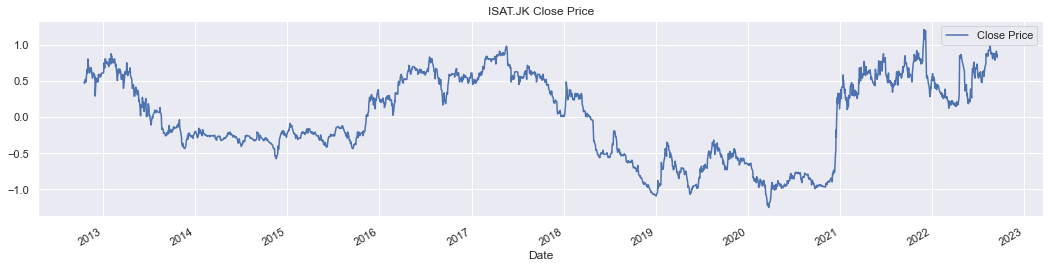

In [3]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('ISAT.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [4]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [6]:
import statsmodels.api as sm

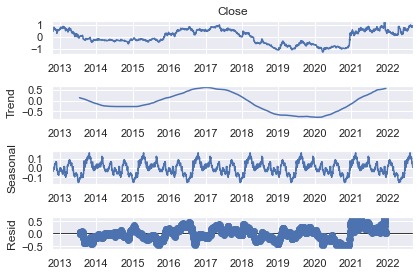

In [7]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [9]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Close Price


In [10]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


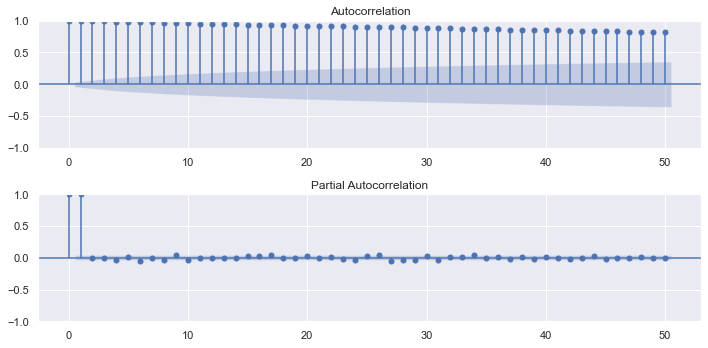

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [12]:
from pmdarima.arima import auto_arima

In [13]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-4205.212, Time=0.63 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-6713.505, Time=1.40 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-5426.778, Time=1.73 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-4203.799, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-6175.246, Time=0.54 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-6858.393, Time=1.93 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-4212.486, Time=1.06 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-6861.906, Time=3.70 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=-6716.380, Time=2.19 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=3.01 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=-6862.1

In [14]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, [1], 5)   Log Likelihood                3597.960
Date:                             Wed, 23 Nov 2022   AIC                          -7177.921
Time:                                     20:31:18   BIC                          -7127.685
Sample:                                          0   HQIC                         -7159.457
                                            - 1967                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.396e-08   9.44e-05     -0.000      1.000      -0.000       0.000
ar.L1          1.1158      0.017     64.496      0.000       1.082       1.150
ar.L2         -0.2424      0.025     -9.514      0.000      -0.292      -0.192
ar.L3          0.1091      0.027      4.015      0.000       0.056       0.162
ar.L4         -0.0055      0.020     -0.279      0.780      -0.044       0.033
ar.S.L5       -0.0655      0.024     -2.703      0.007      -0.113      -0.018
ar.S.L10       0.0398      0.022      1.807      0.071      -0.003       0.083
ma.S.L5       -0.8982      0.017    -52.294      0.000      -0.932      -0.864
sigma2         0.0016   2.77e-05     55.996      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                  35.45   Jarque-Bera (JB):              3191.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.21
Prob(H) (two-sided):                  0.09   Kurtosis:                         9.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

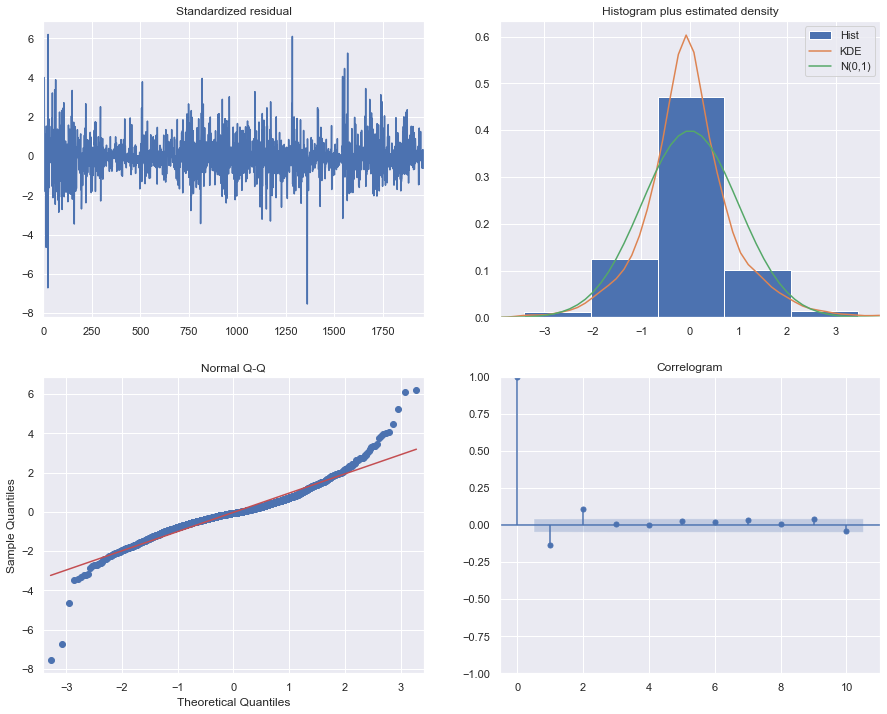

In [15]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(4,0,0), seasonal_order=(2,1,1,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, [1], 5)   Log Likelihood                5343.333
Date:                             Wed, 23 Nov 2022   AIC                         -10636.667
Time:                                     20:32:11   BIC                         -10497.124
Sample:                                          0   HQIC                        -10585.380
                                            - 1967                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1388      0.031      4.536      0.000       0.079       0.199
14 DAYS MA         0.1241      0.058      2.137      0.033       0.010       0.238
21 DAYS MA         0.2060      0.051      4.001      0.000       0.105       0.307
7 DAYS STD DEV    -0.0015      0.001     -1.611      0.107      -0.003       0.000
RSI 7              0.0902      0.005     16.460      0.000       0.079       0.101
RSI 14            -0.3939      0.020    -19.708      0.000      -0.433      -0.355
RSI 21             0.4724      0.015     30.652      0.000       0.442       0.503
MFI 7             -0.0005      0.001     -0.395      0.693      -0.003       0.002
MFI 14            -0.0003      0.002     -0.183      0.855      -0.004       0.003
MFI 21            -0.0053      0.002     -2.671      0.008      -0.009      -0.001
dayofweek         -0.0003      0.001     -0.461      0.645      -0.001       0.001
quarter           -0.0066      0.007     -0.909      0.363      -0.021       0.008
month              0.3086      0.395      0.782      0.434      -0.465       1.082
year              -0.3725      0.271     -1.372      0.170      -0.905       0.160
dayofyear         -0.3389      0.398     -0.853      0.394      -1.118       0.440
dayofmonth         0.0234      0.032      0.721      0.471      -0.040       0.087
weekofyear        -0.0017      0.005     -0.340      0.734      -0.012       0.008
ar.L1              0.7557      0.017     44.202      0.000       0.722       0.789
ar.L2              0.0529      0.024      2.162      0.031       0.005       0.101
ar.L3             -0.0013      0.025     -0.051      0.959      -0.051       0.048
ar.L4              0.0488      0.020      2.448      0.014       0.010       0.088
ar.S.L5           -0.3554      0.049     -7.202      0.000      -0.452      -0.259
ar.S.L10          -0.1422      0.035     -4.102      0.000      -0.210      -0.074
ma.S.L5           -0.3926      0.056     -7.004      0.000      -0.502      -0.283
sigma2             0.0003   4.51e-06     55.813      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 113.05   Jarque-Bera (JB):             11066.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [21]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [23]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [24]:
predictions

,Pred,Actual
Date,,
2020-09-10,-0.957196,-0.943262
2020-09-11,-0.871762,-0.882979
2020-09-14,-0.866674,-0.879433
2020-09-15,-0.913724,-0.911348
2020-09-16,-0.919730,-0.911348
...,...,...
2022-09-12,-0.083521,0.872340
2022-09-13,-0.065991,0.907801
2022-09-14,-0.111217,0.845745


<AxesSubplot:xlabel='Date'>

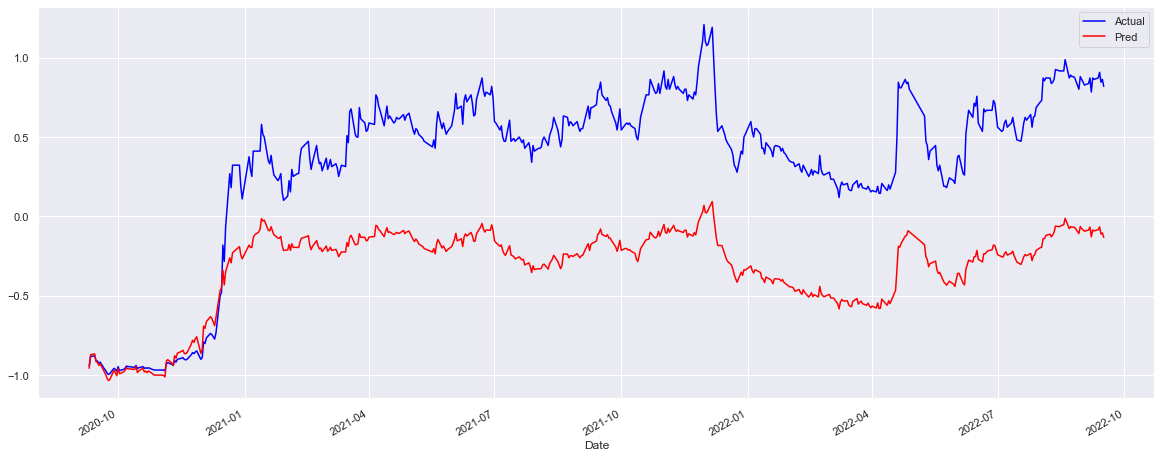

In [25]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [26]:
from joblib import load

In [27]:
close_scaler = load('../feature_engineering/isat_close_scaler.bin')

In [28]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [29]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,2040.706459,2080.0
2020-09-11,2281.630679,2250.0


**Plot Error Distribution**

In [30]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

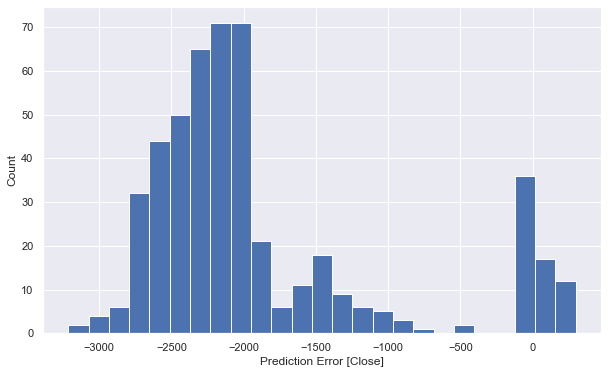

In [31]:
plt.figure(figsize=(10,6))
plotErrorHist(inversed)

**RMSE**

In [32]:
from statsmodels.tools.eval_measures import rmse

In [33]:
rmse(inversed['Pred'], inversed['Actual'])

2062.8813370082444

**MAPE**

In [34]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [35]:
mape(inversed['Actual'], inversed['Pred'])

30.564719297571713

**R-squared**

In [36]:
from sklearn.metrics import r2_score

In [37]:
r2_score(inversed['Actual'], inversed['Pred'])

-0.8809481297529511

### Save the model

In [38]:
from joblib import dump, load
dump(results, './models/isat.joblib') 

['./models/isat.joblib']

In [39]:
loaded = load('./models/isat.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, [1], 5)   Log Likelihood                5343.333
Date:                             Wed, 23 Nov 2022   AIC                         -10636.667
Time:                                     20:33:29   BIC                         -10497.124
Sample:                                          0   HQIC                        -10585.380
                                            - 1967                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1388      0.031      4.536      0.000       0.079       0.199
14 DAYS MA         0.1241      0.058      2.137      0.033       0.010       0.238
21 DAYS MA         0.2060      0.051      4.001      0.000       0.105       0.307
7 DAYS STD DEV    -0.0015      0.001     -1.611      0.107      -0.003       0.000
RSI 7              0.0902      0.005     16.460      0.000       0.079       0.101
RSI 14            -0.3939      0.020    -19.708      0.000      -0.433      -0.355
RSI 21             0.4724      0.015     30.652      0.000       0.442       0.503
MFI 7             -0.0005      0.001     -0.395      0.693      -0.003       0.002
MFI 14            -0.0003      0.002     -0.183      0.855      -0.004       0.003
MFI 21            -0.0053      0.002     -2.671      0.008      -0.009      -0.001
dayofweek         -0.0003      0.001     -0.461      0.645      -0.001       0.001
quarter           -0.0066      0.007     -0.909      0.363      -0.021       0.008
month              0.3086      0.395      0.782      0.434      -0.465       1.082
year              -0.3725      0.271     -1.372      0.170      -0.905       0.160
dayofyear         -0.3389      0.398     -0.853      0.394      -1.118       0.440
dayofmonth         0.0234      0.032      0.721      0.471      -0.040       0.087
weekofyear        -0.0017      0.005     -0.340      0.734      -0.012       0.008
ar.L1              0.7557      0.017     44.202      0.000       0.722       0.789
ar.L2              0.0529      0.024      2.162      0.031       0.005       0.101
ar.L3             -0.0013      0.025     -0.051      0.959      -0.051       0.048
ar.L4              0.0488      0.020      2.448      0.014       0.010       0.088
ar.S.L5           -0.3554      0.049     -7.202      0.000      -0.452      -0.259
ar.S.L10          -0.1422      0.035     -4.102      0.000      -0.210      -0.074
ma.S.L5           -0.3926      0.056     -7.004      0.000      -0.502      -0.283
sigma2             0.0003   4.51e-06     55.813      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 113.05   Jarque-Bera (JB):             11066.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""